In [13]:
import os
import sys
import time
import pickle

%load_ext autoreload
%autoreload 1
%aimport DkNN,AISE

from collections import Counter

import matplotlib.pyplot   as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from torch.utils.data.dataset import random_split
from torchvision              import datasets 
from torchvision              import transforms

from DkNN import CKNN
import utilities
from mnist_model import CNN
from attack import PGD
from AISE import *

device = torch.device('cuda')
config = utilities.config_to_namedtuple(utilities.get_config('config_mnist.json'))

mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=False, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1,))
]))
mnist_testset = datasets.MNIST(root='./datasets', train=False, download=False, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1,))
]))

train_loader = torch.utils.data.DataLoader(mnist_trainset,
    shuffle = True,
    batch_size = 64
)


test_loader = torch.utils.data.DataLoader(mnist_testset,
    shuffle = False,
    batch_size = 64
)

filename = 'models/mnistmodel.pt'
model = CNN().to(device)

if os.path.isfile(filename):
    print("=> loading checkpoint '{}'".format(filename))
    checkpoint = torch.load(filename,map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
              .format(filename, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(filename))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
=> loading checkpoint 'models/mnistmodel.pt'
=> loaded checkpoint 'models/mnistmodel.pt' (epoch 55)


In [32]:
def feature_space(net, n_layers, inputs, labels, device, batch_size=128):

    conv_features = [[] for _ in range(n_layers)]
    targets       = []
    predictions   = []
    print('\tRunning predictions')
    net.eval()
    for ind in range(0,inputs.size(0),batch_size):
        X,y = inputs[ind:ind+batch_size],labels[ind:ind+batch_size]
        *out_convs, out = net(X.to(device))
        y_pred = torch.max(out,1)[1]
        for i, out_conv in enumerate(out_convs):
            conv_feat = out_conv.view(out_conv.size(0), -1).detach().cpu()
            conv_features[i].append(conv_feat)
        targets.append(y.numpy())
        predictions.append(y_pred.detach().cpu().numpy())
    print('\tConcatenating results')
    conv_features = [torch.cat(out_convs) for out_convs in conv_features]
    targets       = np.concatenate(targets)
    predictions   = np.concatenate(predictions)

    return conv_features, targets, predictions

model.eval()

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [51]:
np.random.seed(1234)
ind_full = np.arange(60000)
np.random.shuffle(ind_full)
ind_partial = ind_full[:5000]
X_train_partial = mnist_trainset.data[ind_partial].unsqueeze(1)/255.
y_train_partial = mnist_trainset.targets[ind_partial]

In [52]:
ind_eval = ind_full[5000:5500]
X_eval = mnist_trainset.data[ind_eval].unsqueeze(1)/255.
y_eval = mnist_trainset.targets[ind_eval]

In [60]:
X_adv = PGD(eps=40/255.,sigma=20/255.,nb_iter=20,DEVICE=device).attack_batch(model,X_eval.to(device),y_eval.to(device),batch_size=64)
*_,out = model(X_adv)
y_pred_adv = torch.max(out,1)[1]
print('The accuracy of plain cnn under PGD attacks is: {:f}'.format((y_eval.numpy()==y_pred_adv.detach().cpu().numpy()).mean())) 

The accuracy of plain cnn under PGD attacks is: 0.198000


In [61]:
X_hidden_partial, _, _ = feature_space(model, 4, X_train_partial, y_train_partial, device, 128)

	Running predictions
	Concatenating results


### Comparison between AISE and plain KNN

### random mutation

In [123]:
aise = AISE(X_train_partial,y_train_partial,model=model,mut_mode="random",fitness_function=neg_l2_dist)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 5000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 420.468558549881s.
The accuracy of majority voting by AISE against adversarial samples is: 0.842
The accuaracy of plain KNN against adversarial samples is: 0.814


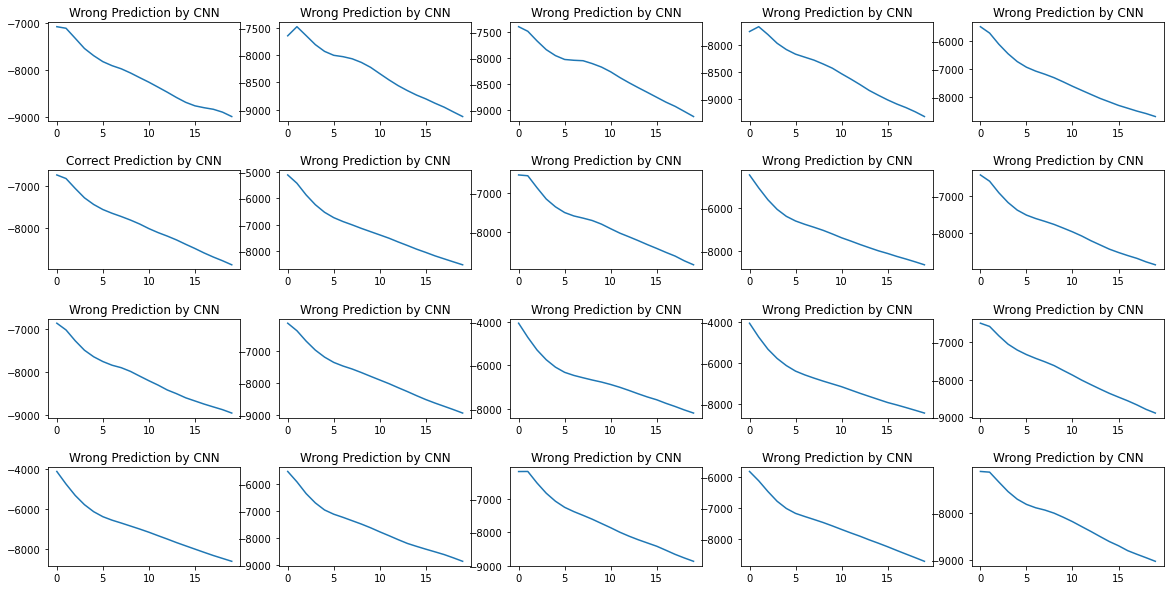

In [125]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')

Text(0.5, 1.0, 'Histogram of KNN confidence')

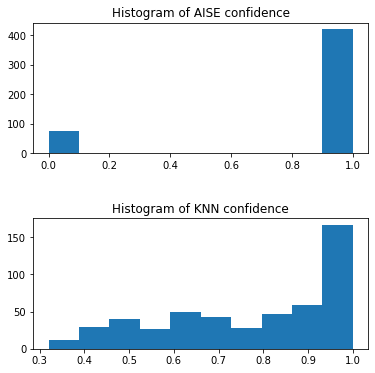

In [124]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

In [133]:
aise = AISE(X_train_partial,y_train_partial,model=model,mut_mode="random",fitness_function=neg_l2_dist,decay=(.9,.9))
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 5000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 437.78641176223755s.
The accuracy of majority voting by AISE against adversarial samples is: 0.846
The accuaracy of plain KNN against adversarial samples is: 0.814


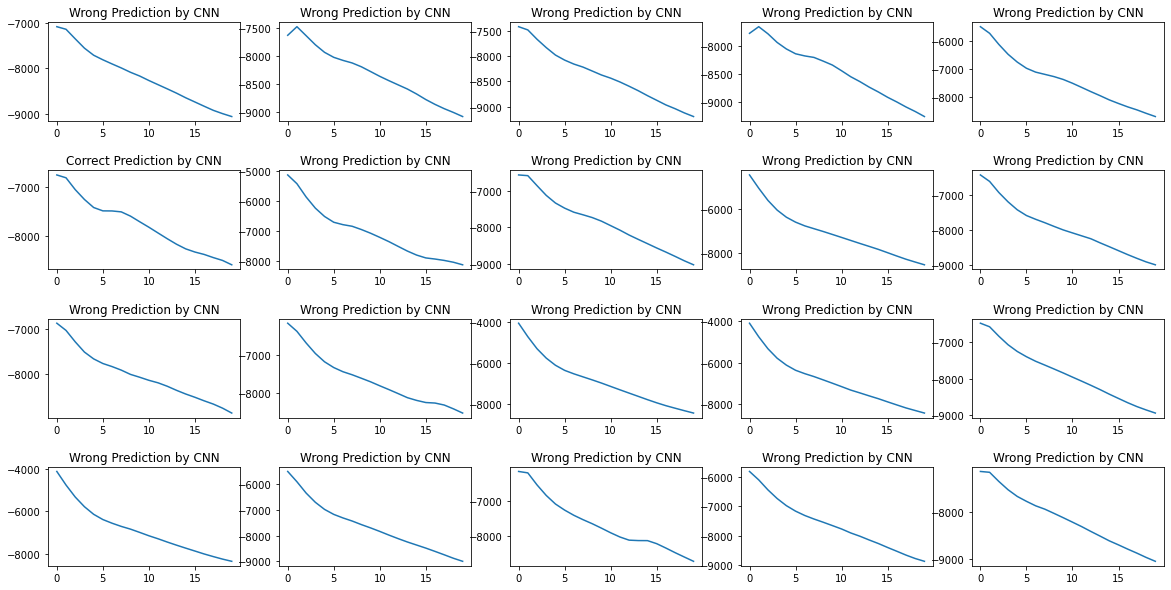

In [134]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')

### guided mutation

In [127]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,decay=(.9,.9))
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 5000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 415.6157374382019s.
The accuracy of majority voting by AISE against adversarial samples is: 0.85
The accuaracy of plain KNN against adversarial samples is: 0.814


Text(0.5, 1.0, 'Histogram of KNN confidence')

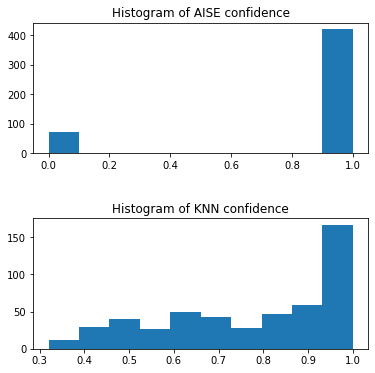

In [129]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

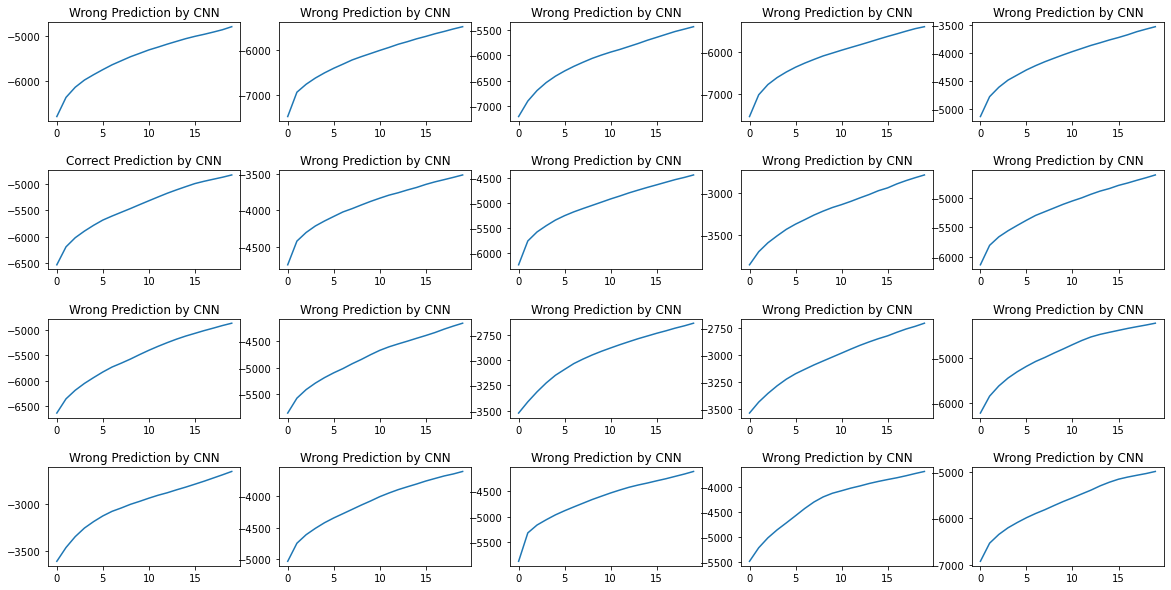

In [128]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')

### guided mutation combined with random(uniform) mutation

In [83]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,mut_mode="combined",combine_prob=.3)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 5000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 461.7497880458832s.
The accuracy of majority voting by AISE against adversarial samples is: 0.858
The accuaracy of plain KNN against adversarial samples is: 0.814


Text(0.5, 1.0, 'Histogram of KNN confidence')

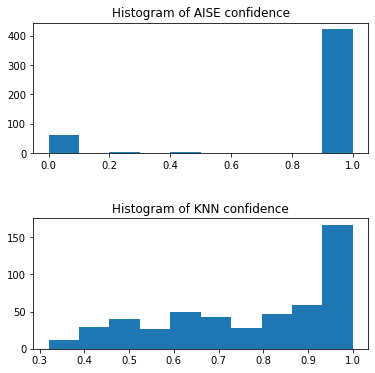

In [84]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

#### combine prob = .5

In [85]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,mut_mode="combined",combine_prob=.5)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 5000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 444.31441473960876s.
The accuracy of majority voting by AISE against adversarial samples is: 0.864
The accuaracy of plain KNN against adversarial samples is: 0.814


Text(0.5, 1.0, 'Histogram of KNN confidence')

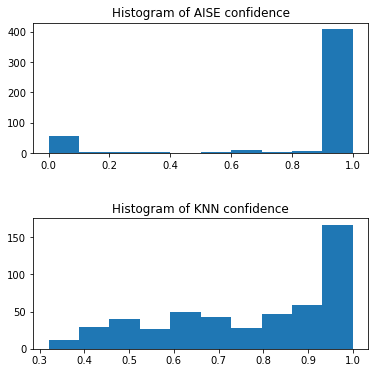

In [87]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

In [96]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,mut_mode="combined",combine_prob=.5)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

Building query objects for 10 classes 5000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 435.6462199687958s.
The accuracy of majority voting by AISE against adversarial samples is: 0.848
The accuaracy of plain KNN against adversarial samples is: 0.814


In [136]:
np.where(knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))!=np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy()))))

(array([  0,  17,  18,  23,  27,  34,  36,  37,  39,  41,  42,  51,  77,
         88,  96, 102, 119, 123, 126, 135, 148, 149, 151, 152, 157, 163,
        170, 171, 173, 183, 194, 198, 199, 205, 209, 217, 218, 237, 240,
        246, 250, 261, 262, 267, 268, 279, 285, 315, 322, 323, 328, 337,
        340, 377, 383, 386, 389, 405, 413, 414, 424, 432, 439, 454, 462,
        474, 481, 489, 498], dtype=int64),)

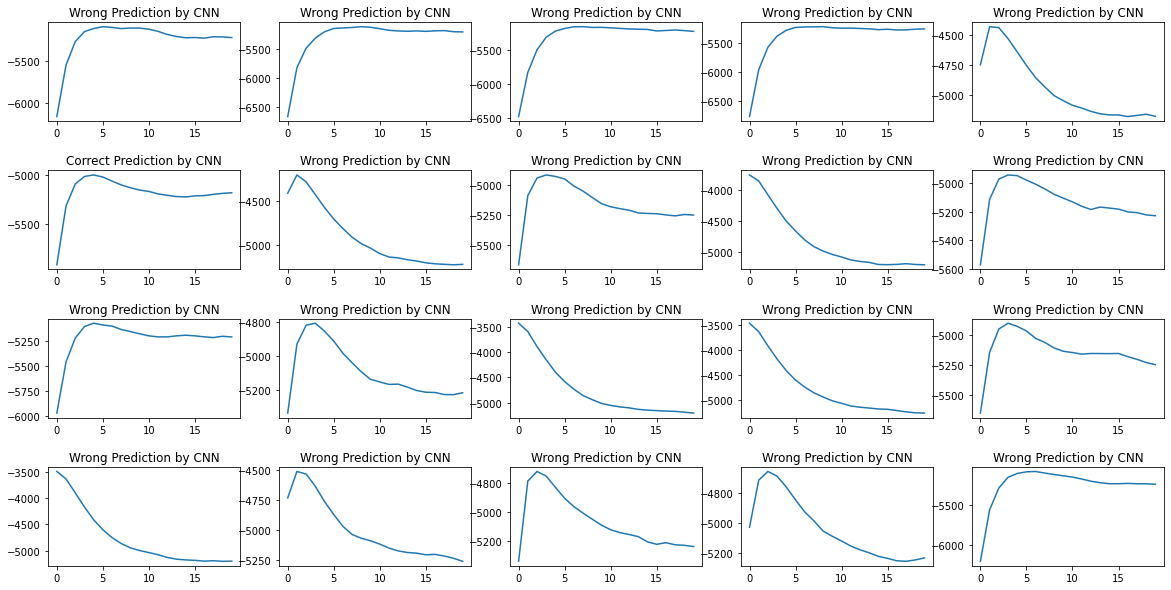

In [111]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=.5)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(fit_log[i])
    plt.title(f'{"Wrong" if y_pred_adv[i].item()!=y_eval[i].item() else "Correct"} Prediction by CNN')
plt.savefig('Population fitness score.jpg')

In [ ]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

#### combine prob = 1.

Building query objects for 10 classes 5000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 500 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
25000 plasma B cells and 100000 memory generated!
Total running time is 444.91861057281494s.
The accuracy of majority voting by AISE against adversarial samples is: 0.852
The accuaracy of plain KNN against adversarial samples is: 0.814


Text(0.5, 1.0, 'Histogram of KNN confidence')

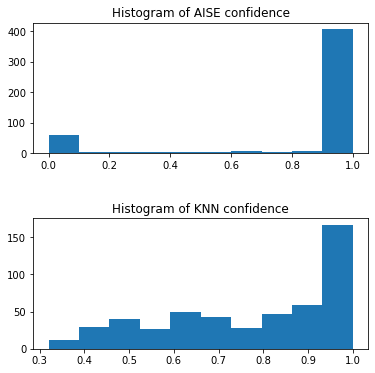

In [89]:
aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,mut_mode="combined",combine_prob=1.)
start_time = time.time()
mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
end_time = time.time()
print("Total running time is {}s.".format(end_time-start_time))
y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=.5)
plt.subplot(2,1,1)
plt.hist((pla_labs==y_eval.reshape(-1,1)).float().mean(dim=1))
plt.title('Histogram of AISE confidence')
plt.subplot(2,1,2)
plt.hist(knn.predict_proba(X_adv.detach().cpu().flatten(start_dim=1).numpy()).max(axis=1))
plt.title('Histogram of KNN confidence')

In [ ]:
# grid search
param_dict = {
# 'mut_range':[.15,.3,.4],
'mut_range':[.15],
'mut_prob':[.05,.1,.2],
'combine_prob':[.3,.5,.7],
'layer_dims':[[],[0,],[1,]],
# max_generation:[10,20,30]
}

import itertools

def dict2str(d):
  s = []
  for k,v in d.items():
    s.append(f'{k}={v}')
  return ','.join(s)

def gridsearch(func,param_dict):
  val_product = list(itertools.product(*param_dict.values()))
  print('{} sets of hyperparameters found!'.format(len(list(val_product))))
  print('Grid search starts...')
  result_dict = {}
  for vs in val_product:
    temp_dict = dict(zip(param_dict.keys(),vs))
    print('# {}'.format(dict2str(temp_dict)))
    temp_metric = func(**temp_dict)
    # print('acc: {}'.format(temp_metric))
    result_dict[dict2str(temp_dict)] = temp_metric
  return result_dict

def test_aise(mut_range,mut_prob,combine_prob,layer_dims,X_orig=X_train_partial,y_orig=y_train_partial,X_hidden=X_hidden_partial,ant=X_adv,y_true=y_eval,
              model=model,device=DEVICE):
  aise = AISE(X_orig,y_orig,X_hidden,combine_prob=combine_prob,mut_range=mut_range,mut_prob=mut_prob,layer_dims=layer_dims,model=model,fitness_function=neg_l2_dist,device=device)
  start_time = time.time()
  mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
  end_time = time.time()
  print("Total running time is {}s.".format(end_time-start_time))
  y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
  acc = (y_pred==y_eval.numpy()).mean()
  print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format(acc))
  return acc

In [78]:
# aise = AISE(X_train_partial,y_train_partial,model=model)
# start_time = time.time()
# mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
# end_time = time.time()
# print("Total running time is {}s.".format(end_time-start_time))
# y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
# print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
# y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
# print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# Building query objects for 10 classes 2000 samples...done!
# Clonal expansion starts...
# Searching 10 naive B cells per class for each of 100 antigens...done!
# Affinity maturation process starts with population of 1000...
# Memory & plasma B cells generated!
# 5000 plasma B cells and 20000 memory generated!
# Total running time is 90.04372024536133s.
# The accuracy of majority voting by AISE against adversarial samples is: 0.57
# The accuaracy of plain KNN against adversarial samples is: 0.84

In [79]:
# aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist,requires_init=True)
# start_time = time.time()
# mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
# end_time = time.time()
# print("Total running time is {}s.".format(end_time-start_time))
# y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
# print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
# y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
# print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# Building query objects for 10 classes 2000 samples...done!
# Clonal expansion starts...
# Searching 10 naive B cells per class for each of 100 antigens...done!
# Affinity maturation process starts with population of 1000...
# Memory & plasma B cells generated!
# 5000 plasma B cells and 20000 memory generated!
# Total running time is 92.43798041343689s.
# The accuracy of majority voting by AISE against adversarial samples is: 0.83
# The accuaracy of plain KNN against adversarial samples is: 0.84

In [80]:
# aise = AISE(X_train_partial,y_train_partial,model=model,fitness_function=neg_l2_dist)
# start_time = time.time()
# mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_eval.cpu(),return_log=True)
# end_time = time.time()
# print("Total running time is {}s.".format(end_time-start_time))
# y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
# print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
# y_pred = knn.predict(X_eval.cpu().numpy().reshape(X_adv.size(0),-1))
# print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# Building query objects for 10 classes 2000 samples...done!
# Clonal expansion starts...
# Searching 10 naive B cells per class for each of 100 antigens...done!
# Affinity maturation process starts with population of 1000...
# Memory & plasma B cells generated!
# 5000 plasma B cells and 20000 memory generated!
# Total running time is 89.55770754814148s.
# The accuracy of majority voting by AISE against adversarial samples is: 0.94
# The accuaracy of plain KNN against adversarial samples is: 0.93

In [38]:
X_hidden_partial[2].size()

torch.Size([2000, 25088])

In [47]:
# aise = AISE(X_train_partial,y_train_partial,X_hidden_partial,(1,),model=model)
# start_time = time.time()
# mem_bcs,mem_labs,pla_bcs,pla_labs = aise.clonal_expansion(X_adv.cpu())
# end_time = time.time()
# print("Total running time is {}s.".format(end_time-start_time))
# y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
# print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
# y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
# print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# Hidden representation found!
# Concatenating the input and hidden representations...
# Building query objects for 10 classes 2000 samples...done!
# Clonal expansion starts...
# Searching 10 naive B cells per class for each of 100 antigens...done!
# Affinity maturation process starts with population of 1000...
# Memory & plasma B cells generated!
# 5000 plasma B cells and 20000 memory generated!
# Total running time is 1377.9193959236145s.
# The accuracy of majority voting by AISE against adversarial samples is: 0.53
# The accuaracy of plain KNN against adversarial samples is: 0.84

SyntaxError: invalid syntax (<ipython-input-47-59f0ca97ba7e>, line 14)

In [41]:
# aise = AISE(X_train_partial,y_train_partial,X_hidden_partial,(1,),model=model,fitness_function=neg_l2_dist)
# start_time = time.time()
# mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
# end_time = time.time()
# print("Total running time is {}s.".format(end_time-start_time))
# y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
# print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
# y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
# print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# Hidden representation found!
# Concatenating the input and hidden representations...
# Building query objects for 10 classes 2000 samples...done!
# Clonal expansion starts...
# Searching 10 naive B cells per class for each of 100 antigens...done!
# Affinity maturation process starts with population of 1000...
# Memory & plasma B cells generated!
# 5000 plasma B cells and 20000 memory generated!
# Total running time is 1342.864268541336s.
# The accuracy of majority voting by AISE against adversarial samples is: 0.84
# The accuaracy of plain KNN against adversarial samples is: 0.84


Hidden representation found!
Concatenating the input and hidden representations...
Building query objects for 10 classes 2000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 100 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
5000 plasma B cells and 20000 memory generated!
Total running time is 1342.864268541336s.
The accuracy of majority voting by AISE against adversarial samples is: 0.84
The accuaracy of plain KNN against adversarial samples is: 0.84


In [43]:
# aise = AISE(X_train_partial,y_train_partial,X_hidden_partial,(0,),model=model,fitness_function=neg_l2_dist)
# start_time = time.time()
# mem_bcs,mem_labs,pla_bcs,pla_labs,fit_log = aise.clonal_expansion(X_adv.cpu(),return_log=True)
# end_time = time.time()
# print("Total running time is {}s.".format(end_time-start_time))
# y_pred = np.array(list(map(lambda x: Counter(x).most_common(1)[0][0],pla_labs.numpy())))
# print('The accuracy of majority voting by AISE against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_partial.flatten(start_dim=1).numpy(),y_train_partial.numpy())
# y_pred = knn.predict(X_adv.cpu().numpy().reshape(X_adv.size(0),-1))
# print('The accuaracy of plain KNN against adversarial samples is: {}'.format((y_pred==y_eval.numpy()).mean()))

# Hidden representation found!
# Concatenating the input and hidden representations...
# Building query objects for 10 classes 2000 samples...done!
# Clonal expansion starts...
# Searching 10 naive B cells per class for each of 100 antigens...done!
# Affinity maturation process starts with population of 1000...
# Memory & plasma B cells generated!
# 5000 plasma B cells and 20000 memory generated!
# Total running time is 1386.992157459259s.
# The accuracy of majority voting by AISE against adversarial samples is: 0.84
# The accuaracy of plain KNN against adversarial samples is: 0.84

Hidden representation found!
Concatenating the input and hidden representations...
Building query objects for 10 classes 2000 samples...done!
Clonal expansion starts...
Searching 10 naive B cells per class for each of 100 antigens...done!
Affinity maturation process starts with population of 1000...
Memory & plasma B cells generated!
5000 plasma B cells and 20000 memory generated!
Total running time is 1386.992157459259s.
The accuracy of majority voting by AISE against adversarial samples is: 0.84
The accuaracy of plain KNN against adversarial samples is: 0.84
